In [1]:
using Turing
using DataFrames
using CSV
using Distributions
using StatsFuns
using StatsPlots
using StatsBase
using Random

default(label=false);

## Using experimental data (first half of the lecture notes)

In [ ]:
d = DataFrame(CSV.File("data/reedfrogs.csv"))
describe(d)

d.tank = 1:nrow(d)
d


### Conventional single-level model

In [ ]:
@model function frog_single_level(S, N, tank)

    a = zeros(length(tank))
    for i in 1:length(tank)
        a[i] ~ Normal(0, 1.5)
    end
    
    for i in 1:length(tank)
        p = logistic(a[i])  # probability of survival or proportional survival
        S[i] ~ Binomial(N[i], p)
    end

end

#@model function frog_single_level(S, N, tank)
#
#    a ~ filldist(Normal(0, 1.5), length(tank))  # offsets are defined for each tank
#    p = logistic.(a)  # probability of survival or proportional survival
#    S .~ Binomial.(N, p)
#
#end

In [ ]:
Random.seed!(1)
frog_single_level_ch = sample(frog_single_level(d.surv, d.density, d.tank), NUTS(200, 0.65, init_ϵ=0.5), 1000);
frog_single_level_df = DataFrame(frog_single_level_ch)

### Multilevel model

In [ ]:
@model function frog_multi_level(S, N, tank)

    σ ~ Exponential()
    ā ~ Normal(0, 1.5)

    a = zeros(length(tank))  # fancier way: a = Vector{Real}(undef, length(tank))
    for i in 1:length(tank)
        a[i] ~ Normal(ā, σ)
    end
    
    for i in 1:length(tank)
        p = logistic(a[i])  # probability of survival or proportional survival
        S[i] ~ Binomial(N[i], p)
    end

end


# @model function frog_multi_level(S, N, tank)

#     σ ~ Exponential()
#     ā ~ Normal(0, 1.5)

#     a ~ filldist(Normal(ā, σ), length(tank))
#     p = logistic.(a)
#     S .~ Binomial.(N, p)

# end

In [ ]:
Random.seed!(1)
frog_multi_level_ch = sample(frog_multi_level(d.surv, d.density, d.tank), NUTS(200, 0.65, init_ϵ=0.2), 1000)
frog_multi_level_df = DataFrame(frog_multi_level_ch);

### Analysis

In [ ]:
single_level_surival = zeros(nrow(frog_single_level_df), nrow(d));

for j in 1:nrow(frog_single_level_df)
    for i in 1:nrow(d)
        tank_id = d.tank[i]
        tank_density = d.density[i]
        tank_surv = d.surv[i]  
        single_level_surival[j,i] = binomlogpdf(tank_density, logistic(frog_single_level_df[j,"a[$(tank_id)]"]), tank_surv)
    end
end

single_level_surival

In [ ]:
multi_level_survival = zeros(nrow(frog_multi_level_df), nrow(d));

for j in 1:nrow(frog_multi_level_df)
    for i in 1:nrow(d)
        tank_id = d.tank[i]
        tank_density = d.density[i]
        tank_surv = d.surv[i]  
        multi_level_survival[j,i] = binomlogpdf(tank_density, logistic(frog_multi_level_df[j,"a[$(tank_id)]"]), tank_surv)
    end
end

multi_level_survival

In [ ]:
## a "fancier" and more compact way

# link_fun = (chain_df, dr) -> begin
#     a = chain_df[:,"a[$(dr.tank)]"]
#     p = logistic.(a)
#     binomlogpdf.(dr.density, p, dr.surv)
# end

# single_level_survival = map( dr -> link_fun(frog_single_level_df, dr), eachrow(d) )
# single_level_survival = hcat(single_level_survival...)

# multi_level_survival = map( dr -> link_fun(frog_multi_level_df, dr), eachrow(d) )
# multi_level_survival = hcat(multi_level_survival...);


In [ ]:
# sample 10_000 samples again from the multi-level model

post = sample(frog_multi_level_ch, 10000)
post_df = DataFrame(post)


In [ ]:
propsurv_est = [                # array comprehension
    logistic(mean(post_df[:,"a[$i]"]))
    for i ∈ 1:nrow(d)
]

In [ ]:
scatter(propsurv_est, mc=:white, label="model", legend=:topright, xlab="tank", ylab="proportion survival", ylim=(-0.05, 1.05))


In [ ]:
scatter!(d.propsurv, mc=:blue, ms=3, label="data")
hline!([mean(logistic.(post_df.ā))], ls=:dash, c=:black)
vline!([16.5, 32.5], c=:black)
annotate!([
        (8, 0, ("small tanks", 10)),
        (16+8, 0, ("medium tanks", 10)),
        (32+8, 0, ("large tanks", 10))
])


In [ ]:
p1 = plot(xlim=(-3, 4), xlab="Log-odds survival", ylab="Density");

for j in 1:100  # first 100 rows (or samples)
    plot!(Normal(post_df.ā[j], post_df.σ[j]), c=:black, alpha=0.2)
end

## a fancier way
# for r ∈ first(eachrow(post_df), 100)
#     plot!(Normal(r.ā, r.σ), c=:black, alpha=0.2)
# end

p1


In [ ]:
p2 = plot(xlab="Probability survival", ylab="Density", xlim=(-0.1, 1.1));

sim_tanks_logistic = zeros(8000)
for j in 1:8000  # 8000 rows (or samples)
    sim_tanks_logistic[j] = logistic( rand( Normal(post_df.ā[j], post_df.σ[j]) ) )
end
density!(sim_tanks_logistic, lw=2)

# a more compact code using broadcasting
#sim_tanks = rand.(Normal.(post_df.ā[1:8000], post_df.σ[1:8000]));  # we could have used for loops
#density!(logistic.(sim_tanks), lw=2)

plot(p1, p2, size=(800, 400))


## Using synthetic data

### Generate syntheric data

In [2]:
## Varying effects and the underfitting/overfitting trade-off
# Generate a mock data to test the models

Random.seed!(1)

ā = 1.5
σ = 1.5
nponds = 60
Ni = repeat([3, 10, 25, 35], inner=15);

a_pond = rand(Normal(ā, σ), nponds);    # mock "true" data

dsim = DataFrame(pond=1:nponds, Ni=Ni, true_a=a_pond);

dsim.true_p = logistic.(dsim.true_a);

dsim


Row,pond,Ni,true_a,true_p
,Int64,Int64,Float64,Float64
1,1,3,1.5929,0.831024
2,2,3,1.91761,0.871872
3,3,3,0.606263,0.647088
4,4,3,1.56999,0.827782
5,5,3,3.12869,0.958061
6,6,3,-0.864847,0.296328
7,7,3,1.76391,0.853699
8,8,3,2.79807,0.942572
9,9,3,-2.68542,0.0638391


In [3]:
dsim.Si = rand.(Binomial.(dsim.Ni, dsim.true_p));

dsim.p_sim = dsim.Si ./ dsim.Ni;

In [4]:
dsim

Row,pond,Ni,true_a,true_p,Si,p_sim
,Int64,Int64,Float64,Float64,Int64,Float64
1,1,3,1.5929,0.831024,3,1.0
2,2,3,1.91761,0.871872,2,0.666667
3,3,3,0.606263,0.647088,3,1.0
4,4,3,1.56999,0.827782,2,0.666667
5,5,3,3.12869,0.958061,3,1.0
6,6,3,-0.864847,0.296328,1,0.333333
7,7,3,1.76391,0.853699,3,1.0
8,8,3,2.79807,0.942572,3,1.0
9,9,3,-2.68542,0.0638391,0,0.0


### Single-level model

In [5]:
# no pooling (single-level model)
@model function pond_single_level(Si, Ni)

    a_pond = zeros(length(Ni))
    for i in 1:length(Ni)
        a_pond[i] ~ Normal(0, 1.5)
    end
    
    for i in 1:length(Ni)
        p = logistic(a_pond[i])  # probability of survival or proportional survival
        Si[i] ~ Binomial(Ni[i], p)
    end

end

#@model function frog_single_level(S, N, tank)
#
#    a_pond ~ filldist(Normal(0, 1.5), length(Ni))  # offsets are defined for each tank
#    p = logistic.(a_pond)  # probability of survival or proportional survival
#    Si .~ Binomial.(Ni, p)
#
#end

pond_single_level (generic function with 2 methods)

### Multi-level model

In [6]:
# partial pooling using the multi-level model
@model function pond_multi_level(Si, Ni) #, pond)

    σ ~ Exponential()
    ā ~ Normal(0, 1.5)

    a_pond = zeros(length(Ni))  # fancier way: a = Vector{Real}(undef, length(tank))
    for i in 1:length(Ni)
        a_pond[i] ~ Normal(ā, σ)
    end
    
    for i in 1:length(Ni)
        p = logistic(a_pond[i])  # probability of survival or proportional survival
        Si[i] ~ Binomial(Ni[i], p)
    end

    # # a more compact way
    # a_pond ~ filldist(Normal(ā, σ), length(Ni))
    # p = logistic.(a_pond)
    # @. Si ~ Binomial(Ni, p)

end

pond_multi_level (generic function with 2 methods)

### Running MC

In [7]:
Random.seed!(1)
pond_single_level_ch = sample(pond_single_level(dsim.Si, dsim.Ni), NUTS(), 1000);
pond_single_level_df = DataFrame(pond_single_level_ch)

Sampling   0%|                                          |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference /Users/stju/.julia/packages/Turing/0yJdp/src/mcmc/hmc.jl:191
Sampling   0%|▎                                         |  ETA: 0:17:35
Sampling   1%|▍                                         |  ETA: 0:08:48
Sampling   1%|▋                                         |  ETA: 0:05:51
Sampling   2%|▊                                         |  ETA: 0:04:23
Sampling   2%|█                                         |  ETA: 0:03:30
Sampling   3%|█▏                                        |  ETA: 0:02:55
Sampling   3%|█▍                                        |  ETA: 0:02:29
Sampling   4%|█▋                                        |  ETA: 0:02:10
Sampling   4%|█▊                                        |  ETA: 0:01:55
Sampling   5%|██                                        |  ETA: 0:01:44
Sampling   5%|██▏                                       |  ETA: 0:01:34
Sampling   6%|

Row,iteration,chain,a_pond[1],a_pond[2],a_pond[3],a_pond[4],a_pond[5],a_pond[6],a_pond[7],a_pond[8],a_pond[9],a_pond[10],a_pond[11],a_pond[12],a_pond[13],a_pond[14],a_pond[15],a_pond[16],a_pond[17],a_pond[18],a_pond[19],a_pond[20],a_pond[21],a_pond[22],a_pond[23],a_pond[24],a_pond[25],a_pond[26],a_pond[27],a_pond[28],a_pond[29],a_pond[30],a_pond[31],a_pond[32],a_pond[33],a_pond[34],a_pond[35],a_pond[36],a_pond[37],a_pond[38],a_pond[39],a_pond[40],a_pond[41],a_pond[42],a_pond[43],a_pond[44],a_pond[45],a_pond[46],a_pond[47],a_pond[48],a_pond[49],a_pond[50],a_pond[51],a_pond[52],a_pond[53],a_pond[54],a_pond[55],a_pond[56],a_pond[57],a_pond[58],a_pond[59],a_pond[60],lp,n_steps,is_accept,acceptance_rate,log_density,hamiltonian_energy,hamiltonian_energy_error,max_hamiltonian_energy_error,tree_depth,numerical_error,step_size,nom_step_size
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,501,1,2.5843,0.500171,-0.376911,1.25407,2.00439,-1.32181,1.42022,0.601552,-2.60527,-0.145173,-0.101357,-3.10815,-0.211053,1.68597,1.70793,-0.222027,1.96972,0.936382,-1.48406,0.763726,2.48865,0.127037,-1.75685,-0.935014,2.47853,1.97211,3.20317,-0.871668,1.42477,1.64611,2.03916,0.1302,2.19552,0.287714,-2.28266,0.786305,0.891741,1.7572,-0.163188,2.69688,2.10887,1.75604,1.41556,1.78657,4.51498,0.215079,0.593992,1.35288,4.06406,1.32851,1.60746,-0.147351,-0.330797,0.9654,-0.243184,4.01302,3.09676,3.98415,-0.573872,1.00957,-227.714,7.0,1.0,0.617315,-227.714,250.997,1.10832,1.21127,3.0,0.0,0.699572,0.699572
2,502,1,2.14415,-0.454379,3.00497,0.147265,1.21607,0.582726,0.98965,4.05304,-0.538166,-0.40554,-2.18788,1.84172,1.60274,3.48353,2.53981,-1.49966,2.77368,0.309663,-0.277101,1.83205,0.807643,1.39273,-0.746942,-0.767207,2.02002,2.75566,1.39561,-0.97247,0.23265,1.6501,0.691471,-0.472172,2.55591,0.281984,-0.731133,0.677123,0.732979,3.30309,-0.0205672,2.3856,1.53525,1.48778,0.82769,1.31818,3.49893,-0.131373,1.46253,1.62496,1.51509,1.63493,1.90037,0.162395,0.290402,0.66311,0.255073,2.24208,2.34568,3.37657,0.267317,2.58691,-219.771,7.0,1.0,1.0,-219.771,251.303,-0.271128,-1.18799,3.0,0.0,0.699572,0.699572
3,503,1,2.71221,-0.904807,3.32238,0.67282,2.17556,0.706358,0.593389,2.20077,-1.72195,-0.57891,-2.47383,1.66847,2.27503,2.38055,2.64449,-1.62994,2.63624,0.566689,0.54427,2.18257,1.24603,1.13684,-1.01884,-0.565293,2.47133,2.88913,2.48353,-0.497655,0.073432,1.63453,0.168937,-0.418655,2.67773,0.289587,-1.25415,0.675903,0.834076,2.47829,0.374099,2.5628,1.98981,0.707761,0.80918,1.32549,3.33527,0.175066,1.22352,1.50456,1.47999,0.668947,1.84583,-0.159151,0.682923,0.681323,-0.148044,2.23269,2.51786,2.59432,0.155582,3.00893,-227.316,7.0,1.0,0.637676,-227.316,253.155,0.890863,1.51915,3.0,0.0,0.699572,0.699572
4,504,1,5.09307,0.728964,1.2288,-0.171022,2.71784,0.408028,1.1844,2.24798,-1.04971,-1.43187,0.14135,0.491627,2.67564,1.76545,1.71974,-0.897677,1.59926,1.42144,0.467545,3.0106,1.34763,0.519176,-1.43088,-0.209225,3.69611,2.27921,3.5992,-0.65415,1.74224,2.36065,0.969125,0.417742,2.0446,0.107783,-2.02514,0.135074,0.531721,2.02564,-0.709826,1.52905,1.10793,2.71499,1.07616,2.11198,2.36328,0.352356,0.11872,1.35866,3.24891,1.23877,1.64102,-0.969471,-0.401269,0.859913,-0.42934,3.49401,2.75953,3.94912,0.281562,2.1856,-221.958,7.0,1.0,0.963687,-221.958,255.881,-0.789181,-1.08506,3.0,0.0,0.699572,0.699572
5,505,1,1.42332,0.74581,1.7633,1.3718,0.643896,0.432619,0.736127,0.0835759,-0.839571,-0.726252,0.213028,0.403681,1.45988,1.08141,2.13917,-1.3615,2.

In [8]:
Random.seed!(1)
pond_multi_level_ch = sample(pond_multi_level(dsim.Si, dsim.Ni), NUTS(), 1000)
pond_multi_level_df = DataFrame(pond_multi_level_ch)


Sampling   0%|                                          |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/stju/.julia/packages/Turing/0yJdp/src/mcmc/hmc.jl:191
Sampling   0%|▎                                         |  ETA: 0:16:27
Sampling   1%|▍                                         |  ETA: 0:08:14
Sampling   1%|▋                                         |  ETA: 0:05:32
Sampling   2%|▊                                         |  ETA: 0:04:10
Sampling   2%|█                                         |  ETA: 0:03:21
Sampling   3%|█▏                                        |  ETA: 0:02:48
Sampling   3%|█▍                                        |  ETA: 0:02:25
Sampling   4%|█▋                                        |  ETA: 0:02:07
Sampling   4%|█▊                                        |  ETA: 0:01:53
Sampling   5%|██                                        |  ETA: 0:01:42
Sampling   5%|██▏                                       |  ETA: 0:01:33
Sampling   6%|

Row,iteration,chain,σ,ā,a_pond[1],a_pond[2],a_pond[3],a_pond[4],a_pond[5],a_pond[6],a_pond[7],a_pond[8],a_pond[9],a_pond[10],a_pond[11],a_pond[12],a_pond[13],a_pond[14],a_pond[15],a_pond[16],a_pond[17],a_pond[18],a_pond[19],a_pond[20],a_pond[21],a_pond[22],a_pond[23],a_pond[24],a_pond[25],a_pond[26],a_pond[27],a_pond[28],a_pond[29],a_pond[30],a_pond[31],a_pond[32],a_pond[33],a_pond[34],a_pond[35],a_pond[36],a_pond[37],a_pond[38],a_pond[39],a_pond[40],a_pond[41],a_pond[42],a_pond[43],a_pond[44],a_pond[45],a_pond[46],a_pond[47],a_pond[48],a_pond[49],a_pond[50],a_pond[51],a_pond[52],a_pond[53],a_pond[54],a_pond[55],a_pond[56],a_pond[57],a_pond[58],a_pond[59],a_pond[60],lp,n_steps,is_accept,acceptance_rate,log_density,hamiltonian_energy,hamiltonian_energy_error,max_hamiltonian_energy_error,tree_depth,numerical_error,step_size,nom_step_size
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,501,1,1.60809,1.51934,1.90082,1.37521,2.01334,0.624235,1.56387,0.424641,0.815727,1.9893,-2.27689,-0.431566,-0.344614,1.9877,2.13719,3.29573,4.19221,-3.41262,1.09522,1.71026,-0.0323288,2.57969,1.9399,0.506387,-3.62177,0.590395,2.57694,5.18749,2.81074,-1.15147,2.22228,1.60392,2.31665,0.33184,2.90296,-0.384031,-1.06268,2.11425,1.96389,2.5132,-0.429653,1.76907,1.41026,2.2335,1.43057,1.67976,3.7529,-0.165916,0.835508,2.30094,2.57247,1.20971,1.48529,-0.167599,0.358302,0.291657,0.232491,3.9138,2.57712,3.75187,0.460495,1.77239,-209.955,7.0,1.0,0.988339,-209.955,240.113,-0.260639,-0.260639,3.0,0.0,0.511394,0.511394
2,502,1,2.00829,1.12274,3.84163,3.53436,1.5724,1.25573,2.58588,-0.588132,2.38981,2.42071,-0.506899,-0.165258,0.78827,0.232396,3.76919,1.63119,1.78068,-1.97558,2.20723,1.24767,-0.00154472,1.51776,1.29925,1.94227,-1.02655,-0.7575,2.80233,4.24102,2.54478,-0.257749,1.61392,1.86247,0.891004,-0.310418,3.75358,0.947635,-1.29159,0.781787,0.988881,2.43093,-0.107452,0.791049,0.747659,2.79137,0.43217,1.96727,2.3965,0.346439,0.500437,0.68508,3.69057,1.33494,2.22373,0.452029,0.623869,0.742912,0.144063,4.92751,3.67496,3.37889,-0.759803,1.82648,-212.508,7.0,1.0,0.488668,-212.508,245.235,0.801705,1.45352,3.0,0.0,0.511394,0.511394
3,503,1,1.25745,1.48515,0.317154,2.44484,2.70194,0.852969,1.73658,0.0111704,3.03404,2.29833,-2.01697,0.645036,-0.36179,0.944914,0.484265,1.12319,1.98739,-0.266078,2.14578,1.44601,0.165268,1.8671,1.36371,0.91228,-1.44945,0.70174,3.86697,1.09346,2.19539,-0.978054,2.08659,2.75952,2.88008,-0.248901,1.43155,-0.441334,-0.734185,0.864216,0.841729,2.21145,-0.335494,2.04634,1.6411,1.51169,1.32089,1.85555,4.1583,0.169815,1.79014,2.2149,2.81161,1.39007,1.42935,0.170534,0.554851,1.20521,0.607775,3.55342,4.96183,3.8658,0.22506,2.19039,-207.11,7.0,1.0,0.9061,-207.11,246.613,-1.20987,-1.20987,3.0,0.0,0.511394,0.511394
4,504,1,1.40273,1.56597,0.835711,2.24167,2.20422,1.12093,3.00546,-0.501247,1.22071,2.89807,0.572889,-0.390136,-1.61523,1.19592,1.28718,2.92368,3.00637,-1.1986,1.28275,-0.0157598,-0.256901,0.95835,1.86374,0.190992,-1.84206,0.837518,4.76768,3.9759,1.32083,-0.758052,2.00302,1.91653,2.48601,0.545648,3.26628,0.0404763,-0.452696,0.369564,1.37228,1.88533,-0.517479,1.86787,0.65259,2.39168,1.14035,1.83364,3.96163,0.0812019,1.3061,1.80278,2.08191,1.35606,1.2158,0.494436,0.640239,1.05403,0.0798081,3.46438,4.1159,4.60001,0.569409,1.89516,-209.252,7.0,1.0,0.541858,-209.252,242.852,0.537156,0.843004,3.0,0.0,0.511394,0.511394
5,505,1,1.49542,1.25411,2.12286,0.205616,1.61167,1.09221,1.39907,0.663511,1.973

### Analysis of errors

In [9]:
dsim.p_nopool = [
    mean(logistic.(pond_single_level_df[:,"a_pond[$i]"]))
    for i ∈ 1:nponds
]

60-element Vector{Float64}:
 0.7695984071644358
 0.5972882754605999
 0.7777284574137288
 0.5979623626338262
 0.7719246087323853
 0.3998655034859245
 0.7755282933855211
 0.7855254002016874
 0.2266524083522467
 0.40573026413203905
 ⋮
 0.5121304978304645
 0.5423573272681337
 0.6769291023883673
 0.5137830433585063
 0.9559334330189115
 0.9345922393958458
 0.957190444802739
 0.5386221690091739
 0.8632254624025306

In [10]:
dsim.p_partpool = [
    mean(logistic.(pond_multi_level_df[:,"a_pond[$i]"]))
    for i ∈ 1:nponds
]

60-element Vector{Float64}:
 0.8582733324227798
 0.7054335834876009
 0.857029663193707
 0.7105964992849128
 0.8662938071880802
 0.5196399156649973
 0.8589287416161177
 0.8631579908467942
 0.3429014423353111
 0.5247064482039359
 ⋮
 0.5339881157765404
 0.5559260925619918
 0.6917993091929022
 0.530672034352999
 0.9678725718035597
 0.9468930938508748
 0.9665019245383951
 0.5615517668322254
 0.8757690038522556

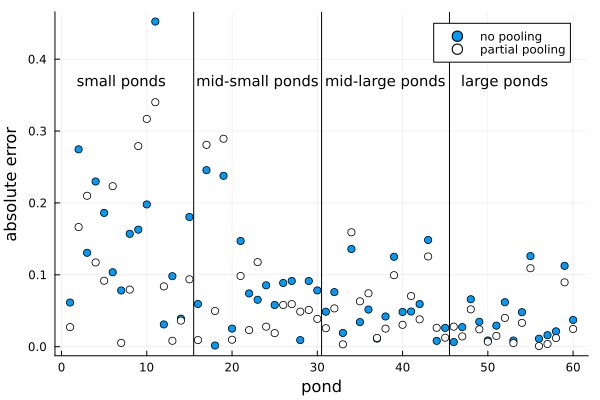

In [11]:
nopool_error = abs.(dsim.p_nopool - dsim.true_p)
partpool_error = abs.(dsim.p_partpool - dsim.true_p);

plt = scatter(nopool_error, xlab="pond", ylab="absolute error", label = "no pooling")
scatter!(partpool_error, mc=:white, label = "partial pooling")

vline!([15.5, 30.5, 45.5], c=:black)
annotate!([
        (7, 0.37, ("small ponds", 10)),
        (16+7, 0.37, ("mid-small ponds", 10)),
        (31+7, 0.37, ("mid-large ponds", 10)),
        (45+7, 0.37, ("large ponds", 10))
])

In [ ]:
dsim.nopool_error = nopool_error;
dsim.partpool_error = partpool_error;

In [ ]:
dsim

### Means of the errors in each cluster

In [ ]:
# group results according to the number of tadpoles
gb = groupby(dsim, :Ni)

In [ ]:
pools = combine(gb, :nopool_error => mean, :partpool_error => mean, :pond => minimum, :pond => maximum)

In [ ]:
pools.pond_minimum, pools.pond_maximum # ranges of pond numbers with the same numbers of tadpoles for plotting purpose


In [ ]:
for i in 1:length(pools.pond_minimum)
    plot!([pools.pond_minimum[i],pools.pond_maximum[i]],[pools.nopool_error_mean[i],pools.nopool_error_mean[i]])
end

for i in 1:length(pools.pond_minimum)
    plot!([pools.pond_minimum[i],pools.pond_maximum[i]],[pools.partpool_error_mean[i],pools.partpool_error_mean[i]], line=:dash)
end

plt